
--------------------------------------------------------------------------------
GRADIENT BOOSTING MODEL FOR BANDGAP PREDICTION - using our MinMax Scaling
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
DATA PREPROCESSING AND FEATURE SELECTION
--------------------------------------------------------------------------------

Loading: dataset_1053.xlsx
Dataset shape: (1053, 57)
Features: 50
Targets: ['band_gap', 'formation_energy']

--------------------------------------------------------------------------------
MinMax Scaling
--------------------------------------------------------------------------------
  Features scaled: 50
  Value range: [0.000000, 1.000000]

--------------------------------------------------------------------------------
Feature Selection for Bandgap Prediction
--------------------------------------------------------------------------------

Pearson C

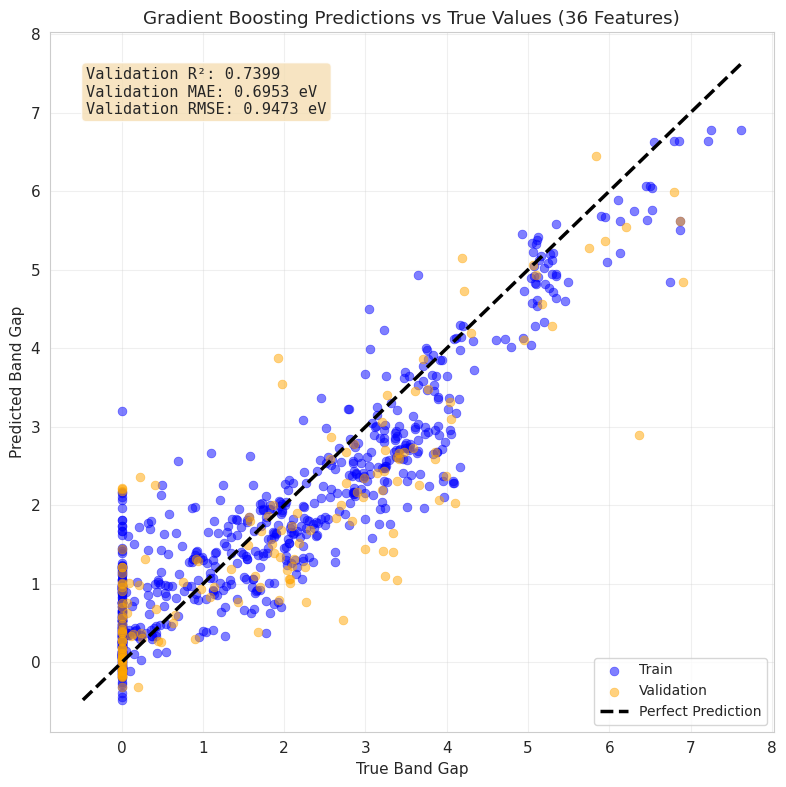

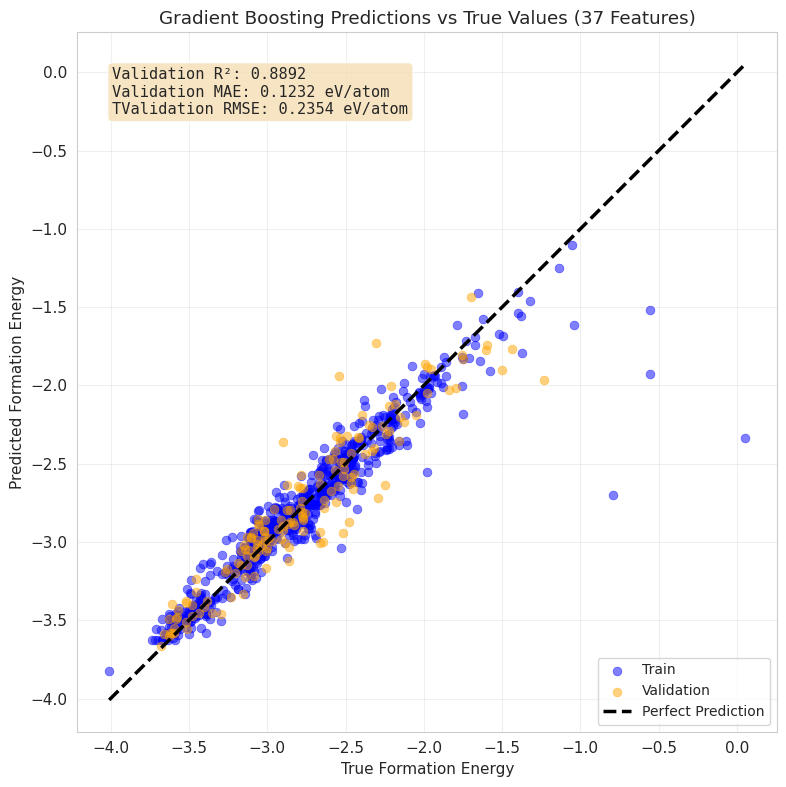

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15 / (1 - TEST_SIZE)
N_CV_FOLDS = 10
CORRELATION_THRESHOLD = 0.90

def minmax_scale_features(df, feature_columns):
    X = df[feature_columns].copy()
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized = pd.DataFrame(X_normalized, columns=feature_columns, index=X.index)
    
    print(f"  Features scaled: {len(feature_columns)}")
    print(f"  Value range: [{X_normalized.min().min():.6f}, {X_normalized.max().max():.6f}]")
    
    return X_normalized, scaler

def pearson_correlation_selection(X_normalized, y_target, correlation_threshold=0.90):
    print(f"\nPearson Correlation Feature Selection")
    print(f"Initial features: {len(X_normalized.columns)}")
    print(f"Correlation threshold: {correlation_threshold}")
    
    mi_scores = mutual_info_regression(X_normalized, y_target, random_state=42)
    mrmr_ranking = pd.Series(mi_scores, index=X_normalized.columns).sort_values(ascending=False)
    
    feature_corr_matrix = X_normalized.corr()
    
    selected_features = set(X_normalized.columns)
    removed_features = []
    
    for i in range(len(feature_corr_matrix.columns)):
        for j in range(i+1, len(feature_corr_matrix.columns)):
            feat_i = feature_corr_matrix.columns[i]
            feat_j = feature_corr_matrix.columns[j]
            
            if feat_i in selected_features and feat_j in selected_features:
                corr_val = abs(feature_corr_matrix.iloc[i, j])
                
                if corr_val > correlation_threshold:
                    if mrmr_ranking[feat_i] < mrmr_ranking[feat_j]:
                        selected_features.remove(feat_i)
                        removed_features.append((feat_i, feat_j, corr_val))
                    else:
                        selected_features.remove(feat_j)
                        removed_features.append((feat_j, feat_i, corr_val))
    
    selected_features = sorted(list(selected_features))
    
    print(f"Removed features: {len(removed_features)}")
    print(f"Final features: {len(selected_features)}")
    
    return selected_features, removed_features

class BandgapPredictor:
    
    def __init__(self, random_state=RANDOM_STATE):
        self.random_state = random_state
        self.scaler = None
        self.gbr_bandgap = None
        self.gbr_formation = None
        self.X_train_bg = None
        self.X_val_bg = None
        self.X_test_bg = None
        self.y_train_bg = None
        self.y_val_bg = None
        self.y_test_bg = None
        self.X_train_fe = None
        self.X_val_fe = None
        self.X_test_fe = None
        self.y_train_fe = None
        self.y_val_fe = None
        self.y_test_fe = None
        
        self.results = {
            'bandgap': {},
            'formation_energy': {}
        }
    
    def load_and_preprocess_data(self, filepath):
        print("\n" + "-"*80)
        print("DATA PREPROCESSING AND FEATURE SELECTION")
        print("-"*80)
        
        print(f"\nLoading: {filepath}")
        self.df = pd.read_excel(filepath)
        print(f"Dataset shape: {self.df.shape}")
        
        identifiers = ['A2BBX6', 'A', 'B1', 'B2', 'X']
        targets = ['band_gap', 'formation_energy']
        feature_columns = [col for col in self.df.columns if col not in identifiers + targets]
        
        print(f"Features: {len(feature_columns)}")
        print(f"Targets: {targets}")
        
        self.y_bandgap = self.df['band_gap'].copy()
        self.y_formation = self.df['formation_energy'].copy()

        print("\n" + "-"*80)
        print("MinMax Scaling")
        print("-"*80)
        
        X_normalized, self.scaler = minmax_scale_features(self.df, feature_columns)
        
        print("\n" + "-"*80)
        print("Feature Selection for Bandgap Prediction")
        print("-"*80)
        
        bandgap_features, bandgap_removed = pearson_correlation_selection(
            X_normalized, self.y_bandgap, CORRELATION_THRESHOLD
        )
        
        print("\n" + "-"*80)
        print("Feature Selection for Formation Energy Prediction")
        print("-"*80)
        
        formation_features, formation_removed = pearson_correlation_selection(
            X_normalized, self.y_formation, CORRELATION_THRESHOLD
        )
        
        self.X_bandgap = X_normalized[bandgap_features]
        self.X_formation = X_normalized[formation_features]
        
        print("\n" + "-"*80)
        print("Output Datasets")
        print("-"*80)
        print(f"Bandgap dataset: {self.X_bandgap.shape}")
        print(f"Formation energy dataset: {self.X_formation.shape}")
        
        self.bandgap_features = bandgap_features
        self.formation_features = formation_features
        self.bandgap_removed = bandgap_removed
        self.formation_removed = formation_removed
    
    def split_data(self):
        print("\n" + "-"*80)
        print("DATA SPLITTING")
        print(""*80)
        
        self.X_train_bg, self.X_test_bg, self.y_train_bg, self.y_test_bg = \
            train_test_split(self.X_bandgap, self.y_bandgap, 
                           test_size=TEST_SIZE, random_state=self.random_state)
        
        self.X_train_bg, self.X_val_bg, self.y_train_bg, self.y_val_bg = \
            train_test_split(self.X_train_bg, self.y_train_bg, 
                           test_size=VAL_SIZE, random_state=self.random_state)
        
        self.X_train_fe, self.X_test_fe, self.y_train_fe, self.y_test_fe = \
            train_test_split(self.X_formation, self.y_formation, 
                           test_size=TEST_SIZE, random_state=self.random_state)
        
        self.X_train_fe, self.X_val_fe, self.y_train_fe, self.y_val_fe = \
            train_test_split(self.X_train_fe, self.y_train_fe, 
                           test_size=VAL_SIZE, random_state=self.random_state)
        
        print(f"\nBandgap Data:")
        print(f"  Training set: {self.X_train_bg.shape[0]} samples (68.8 percent)")
        print(f"  Validation set: {self.X_val_bg.shape[0]} samples (15.0 percent)")
        print(f"  Test set: {self.X_test_bg.shape[0]} samples (15.0 percent)")
        print(f"  Total: {self.X_train_bg.shape[0] + self.X_val_bg.shape[0] + self.X_test_bg.shape[0]} samples")
        
        print(f"\nFormation Energy Data:")
        print(f"  Training set: {self.X_train_fe.shape[0]} samples (68.8 percent)")
        print(f"  Validation set: {self.X_val_fe.shape[0]} samples (15.0 percent)")
        print(f"  Test set: {self.X_test_fe.shape[0]} samples (15.0 percent)")
        print(f"  Total: {self.X_train_fe.shape[0] + self.X_val_fe.shape[0] + self.X_test_fe.shape[0]} samples")
    
    def train_models(self):
        print("\n" + "-"*80)
        print("TRAINING GRADIENT BOOSTING REGRESSION MODELS")
        print("-"*80)
        
        print("\n" + "-"*80)
        print("Gradient Boosting Regressor for Bandgap Prediction")
        print("-"*80)
        
        self.gbr_bandgap = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            subsample=1.0,
            random_state=self.random_state,
            verbose=0
        )
        
        self.gbr_bandgap.fit(self.X_train_bg, self.y_train_bg)
        self._evaluate_model(self.gbr_bandgap, self.X_train_bg, self.X_val_bg, 
                            self.X_test_bg, self.y_train_bg, self.y_val_bg, 
                            self.y_test_bg, 'bandgap')
        
        print("\n" + "-"*80)
        print("Gradient Boosting Regressor for Formation Energy Prediction")
        print("-"*80)
        
        self.gbr_formation = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            subsample=1.0,
            random_state=self.random_state,
            verbose=0
        )
        
        self.gbr_formation.fit(self.X_train_fe, self.y_train_fe)
        self._evaluate_model(self.gbr_formation, self.X_train_fe, self.X_val_fe, 
                            self.X_test_fe, self.y_train_fe, self.y_val_fe, 
                            self.y_test_fe, 'formation_energy')
    
    def _evaluate_model(self, model, X_train, X_val, X_test, 
                       y_train, y_val, y_test, target_name):
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        test_rmse = np.sqrt(test_mse)
        
        self.results[target_name] = {
            'train': {'r2': train_r2, 'mse': train_mse, 'mae': train_mae},
            'val': {'r2': val_r2, 'mse': val_mse, 'mae': val_mae},
            'test': {'r2': test_r2, 'mse': test_mse, 'mae': test_mae, 'rmse': test_rmse},
            'model': model
        }
        
        print(f"\nTraining Set:")
        print(f"  R squared: {train_r2:.4f}")
        print(f"  MSE: {train_mse:.4f}")
        print(f"  MAE: {train_mae:.4f}")
        
        print(f"\nValidation Set:")
        print(f"  R squared: {val_r2:.4f}")
        print(f"  MSE: {val_mse:.4f}")
        print(f"  MAE: {val_mae:.4f}")
        
        print(f"\nTest Set:")
        print(f"  R squared: {test_r2:.4f}")
        print(f"  MSE: {test_mse:.4f}")
        print(f"  MAE: {test_mae:.4f}")
        print(f"  RMSE: {test_rmse:.4f}")
    
    def cross_validation(self):
        print("\n" + "-"*80)
        print("10-FOLD CROSS-VALIDATION")
        print("-"*80)
        
        kf = KFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=self.random_state)
        
        cv_scores_bg = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_bandgap), 1):
            X_train_cv = self.X_bandgap.iloc[train_idx]
            y_train_cv = self.y_bandgap.iloc[train_idx]
            X_val_cv = self.X_bandgap.iloc[val_idx]
            y_val_cv = self.y_bandgap.iloc[val_idx]
            
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                             max_depth=3, random_state=self.random_state)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            r2 = r2_score(y_val_cv, y_pred_cv)
            cv_scores_bg.append(r2)
        
        print("\nBandgap - 10-Fold Cross-Validation R squared Scores:")
        for i, score in enumerate(cv_scores_bg, 1):
            print(f"  Fold {i:2d}: {score:.4f}")
        print(f"  Mean: {np.mean(cv_scores_bg):.4f} (plus-minus {np.std(cv_scores_bg):.4f})")
        
        cv_scores_fe = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_formation), 1):
            X_train_cv = self.X_formation.iloc[train_idx]
            y_train_cv = self.y_formation.iloc[train_idx]
            X_val_cv = self.X_formation.iloc[val_idx]
            y_val_cv = self.y_formation.iloc[val_idx]
            
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                             max_depth=3, random_state=self.random_state)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            r2 = r2_score(y_val_cv, y_pred_cv)
            cv_scores_fe.append(r2)
        
        print("\n\nFormation Energy - 10-Fold Cross-Validation R squared Scores:")
        for i, score in enumerate(cv_scores_fe, 1):
            print(f"  Fold {i:2d}: {score:.4f}")
        print(f"  Mean: {np.mean(cv_scores_fe):.4f} (plus-minus {np.std(cv_scores_fe):.4f})")
        
        return cv_scores_bg, cv_scores_fe
    
    def compare_models(self):
        print("\n" + "-"*80)
        print("MODEL COMPARISON")
        print("-"*80)
        
        results_comparison = []
        
        print("\nBandgap Prediction - Algorithm Comparison:")
        print("-" * 80)
        
        for name, model_class in [('GBR', GradientBoostingRegressor), 
                                  ('RF', RandomForestRegressor)]:
            if name == 'GBR':
                model = model_class(n_estimators=100, learning_rate=0.1, 
                                   max_depth=3, random_state=self.random_state)
            else:
                model = model_class(n_estimators=100, max_depth=10, 
                                   random_state=self.random_state)
            
            model.fit(self.X_train_bg, self.y_train_bg)
            y_pred = model.predict(self.X_test_bg)
            
            r2 = r2_score(self.y_test_bg, y_pred)
            mse = mean_squared_error(self.y_test_bg, y_pred)
            mae = mean_absolute_error(self.y_test_bg, y_pred)
            rmse = np.sqrt(mse)
            
            results_comparison.append({
                'Target': 'Bandgap',
                'Model': name,
                'R_squared': r2,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse
            })
            
            print(f"\n{name}:")
            print(f"  R squared: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        print("\n\nFormation Energy Prediction - Algorithm Comparison:")
        print("-" * 80)
        
        for name, model_class in [('GBR', GradientBoostingRegressor), 
                                  ('RF', RandomForestRegressor)]:
            if name == 'GBR':
                model = model_class(n_estimators=100, learning_rate=0.1, 
                                   max_depth=3, random_state=self.random_state)
            else:
                model = model_class(n_estimators=100, max_depth=10, 
                                   random_state=self.random_state)
            
            model.fit(self.X_train_fe, self.y_train_fe)
            y_pred = model.predict(self.X_test_fe)
            
            r2 = r2_score(self.y_test_fe, y_pred)
            mse = mean_squared_error(self.y_test_fe, y_pred)
            mae = mean_absolute_error(self.y_test_fe, y_pred)
            rmse = np.sqrt(mse)
            
            results_comparison.append({
                'Target': 'Formation Energy',
                'Model': name,
                'R_squared': r2,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse
            })
            
            print(f"\n{name}:")
            print(f"  R squared: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        results_df = pd.DataFrame(results_comparison)
        print("\n\nComparison Summary Table:")
        print(results_df.to_string(index=False))
        
        return results_df
    
    def plot_predictions(self):
        """predicted vs actual plots for both targets with training + validation"""
        
        y_train_pred_bg = self.gbr_bandgap.predict(self.X_train_bg)
        y_val_pred_bg = self.gbr_bandgap.predict(self.X_val_bg)
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(self.y_train_bg, y_train_pred_bg, alpha=0.5, s=40, 
                  label='Train', color='blue', linewidth=0.5)
        ax.scatter(self.y_val_bg, y_val_pred_bg, alpha=0.5, s=40, 
                  label='Validation', color='orange', linewidth=0.5)
        
        min_val = min(self.y_train_bg.min(), self.y_val_bg.min(), 
                     y_train_pred_bg.min(), y_val_pred_bg.min())
        max_val = max(self.y_train_bg.max(), self.y_val_bg.max(),
                     y_train_pred_bg.max(), y_val_pred_bg.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2.5, label='Perfect Prediction')
        
        r2 = self.results['bandgap']['val']['r2']
        mae = self.results['bandgap']['val']['mae']
        rmse = self.results['bandgap']['test']['rmse']
        
        ax.set_xlabel("True Band Gap")
        ax.set_ylabel("Predicted Band Gap")
        ax.set_title("Gradient Boosting Predictions vs True Values (36 Features)")
        
        textstr = f'Validation R²: {r2:.4f}\nValidation MAE: {mae:.4f} eV\nValidation RMSE: {rmse:.4f} eV'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props, family='monospace')
        
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        y_train_pred_fe = self.gbr_formation.predict(self.X_train_fe)
        y_val_pred_fe = self.gbr_formation.predict(self.X_val_fe)
        
        fig, ax = plt.subplots(figsize=(8,8))
        ax.scatter(self.y_train_fe, y_train_pred_fe, alpha=0.5, s=40, 
                  label='Train', color='blue', linewidth=0.5)
        ax.scatter(self.y_val_fe, y_val_pred_fe, alpha=0.5, s=40, 
                  label='Validation', color='orange', linewidth=0.5)
        
        min_val = min(self.y_train_fe.min(), self.y_val_fe.min(),
                     y_train_pred_fe.min(), y_val_pred_fe.min())
        max_val = max(self.y_train_fe.max(), self.y_val_fe.max(), 
                     y_train_pred_fe.max(), y_val_pred_fe.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2.5, label='Perfect Prediction')
        
        r2 = self.results['formation_energy']['val']['r2']
        mae = self.results['formation_energy']['val']['mae']
        rmse = self.results['formation_energy']['test']['rmse']
        
        ax.set_xlabel("True Formation Energy")
        ax.set_ylabel("Predicted Formation Energy")
        ax.set_title("Gradient Boosting Predictions vs True Values (37 Features)")
        
        textstr = f'Validation R²: {r2:.4f}\nValidation MAE: {mae:.4f} eV/atom\nTValidation RMSE: {rmse:.4f} eV/atom'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11, verticalalignment='top', bbox=props, family='monospace')
        
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        plt.tight_layout()
        plt.show()    
   
    def run_full_pipeline(self, filepath):
        print("\n" + "-"*80)
        print("GRADIENT BOOSTING MODEL FOR BANDGAP PREDICTION - using our MinMax Scaling")
        print("-"*80)
        
        self.load_and_preprocess_data(filepath)
        self.split_data()
        self.train_models()
        self.cross_validation()
        self.compare_models()
        
        self.plot_predictions()
        


if __name__ == "__main__":
    predictor = BandgapPredictor(random_state=RANDOM_STATE)
    
    predictor.run_full_pipeline('dataset_1053.xlsx')


--------------------------------------------------------------------------------
GRADIENT BOOSTING MODEL: features selected by paper
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
LOADING PROCESSED DATA
--------------------------------------------------------------------------------

Loading Bandgap data: bandgap_23_features.csv
Shape: (1053, 19)
Columns: 19 total

Loading Formation Energy data: formation_energy_18_features.csv
Shape: (1053, 19)
Columns: 19 total

Bandgap Dataset:
  Features: 18
  Samples: 1053
  Target range: [0.0000, 7.6173]

Formation Energy Dataset:
  Features: 18
  Samples: 1053
  Target range: [-4.0090, 0.0525]

--------------------------------------------------------------------------------
DATA SPLITTING
--------------------------------------------------------------------------------

Bandgap Data:
  Training set: 737 samples (68.8 percent)
  Val

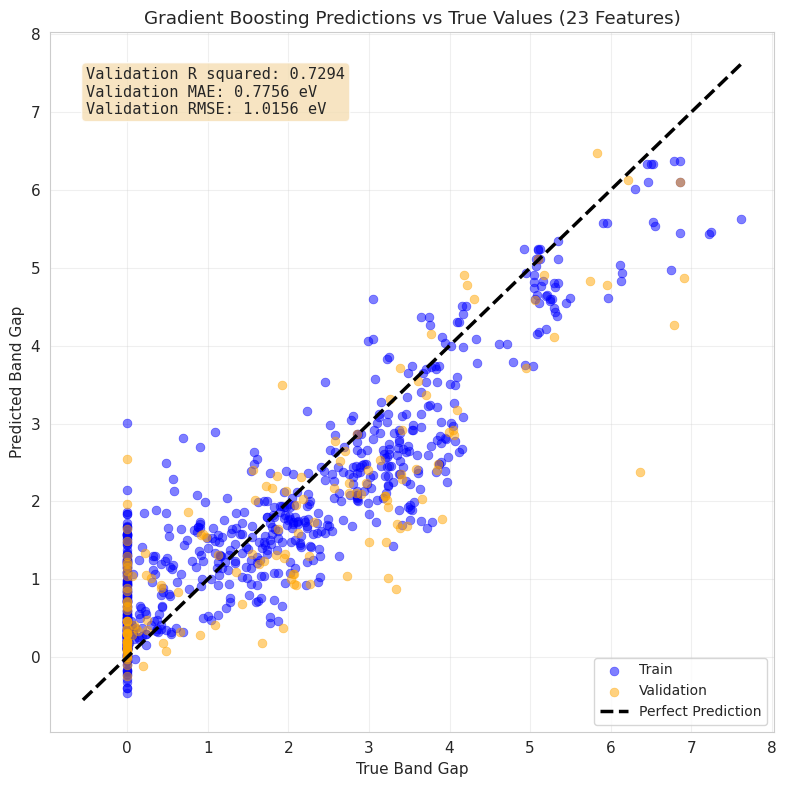

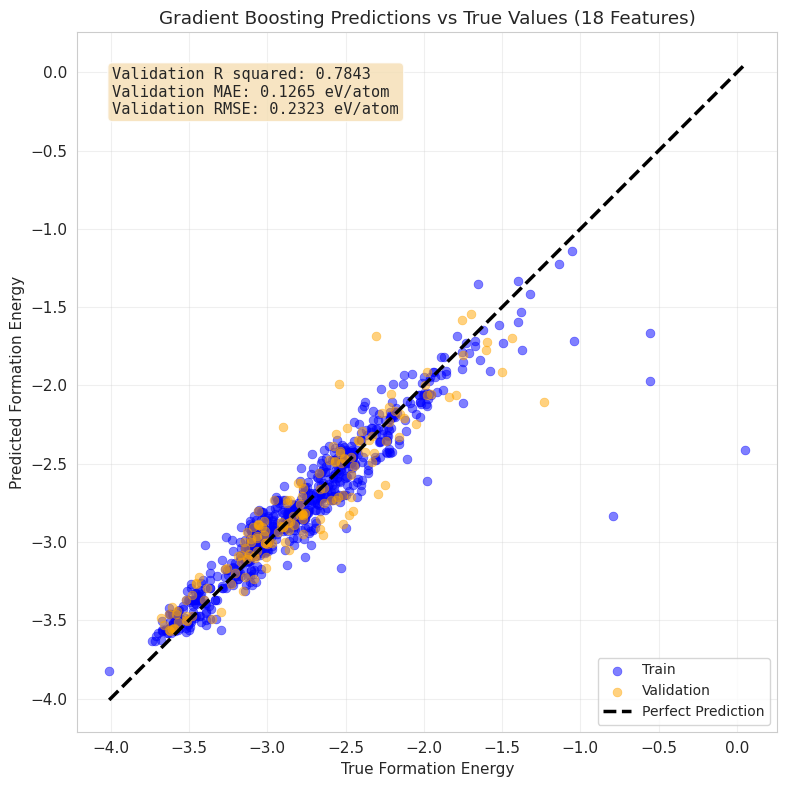

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15 / (1 - TEST_SIZE)
N_CV_FOLDS = 10

class BandgapPredictor:
    
    def __init__(self, random_state=RANDOM_STATE):
        self.random_state = random_state
        self.gbr_bandgap = None
        self.gbr_formation = None
        self.X_train_bg = None
        self.X_val_bg = None
        self.X_test_bg = None
        self.y_train_bg = None
        self.y_val_bg = None
        self.y_test_bg = None
        self.X_train_fe = None
        self.X_val_fe = None
        self.X_test_fe = None
        self.y_train_fe = None
        self.y_val_fe = None
        self.y_test_fe = None
        
        self.results = {
            'bandgap': {},
            'formation_energy': {}
        }
    
    def load_processed_data(self, bandgap_file, formation_file):
        print("\n" + "-"*80)
        print("LOADING PROCESSED DATA")
        print("-"*80)
        
        print(f"\nLoading Bandgap data: {'bandgap_23_features.csv'}")
        df_bandgap = pd.read_csv(bandgap_file)
        print(f"Shape: {df_bandgap.shape}")
        print(f"Columns: {len(df_bandgap.columns)} total")
        
        print(f"\nLoading Formation Energy data: {formation_file}")
        df_formation = pd.read_csv(formation_file)
        print(f"Shape: {df_formation.shape}")
        print(f"Columns: {len(df_formation.columns)} total")
        
        self.df_bandgap = df_bandgap
        self.df_formation = df_formation
        
        self.bandgap_features = [col for col in df_bandgap.columns if col != 'band_gap']
        self.formation_features = [col for col in df_formation.columns if col != 'formation_energy']
        
        self.X_bandgap = df_bandgap[self.bandgap_features]
        self.y_bandgap = df_bandgap['band_gap']
        
        self.X_formation = df_formation[self.formation_features]
        self.y_formation = df_formation['formation_energy']
        
        print(f"\nBandgap Dataset:")
        print(f"  Features: {len(self.bandgap_features)}")
        print(f"  Samples: {len(self.y_bandgap)}")
        print(f"  Target range: [{self.y_bandgap.min():.4f}, {self.y_bandgap.max():.4f}]")
        
        print(f"\nFormation Energy Dataset:")
        print(f"  Features: {len(self.formation_features)}")
        print(f"  Samples: {len(self.y_formation)}")
        print(f"  Target range: [{self.y_formation.min():.4f}, {self.y_formation.max():.4f}]")
    
    def split_data(self):
        print("\n" + "-"*80)
        print("DATA SPLITTING")
        print("-"*80)
        
        self.X_train_bg, self.X_test_bg, self.y_train_bg, self.y_test_bg = \
            train_test_split(self.X_bandgap, self.y_bandgap, 
                           test_size=TEST_SIZE, random_state=self.random_state)
        
        self.X_train_bg, self.X_val_bg, self.y_train_bg, self.y_val_bg = \
            train_test_split(self.X_train_bg, self.y_train_bg, 
                           test_size=VAL_SIZE, random_state=self.random_state)
        
        self.X_train_fe, self.X_test_fe, self.y_train_fe, self.y_test_fe = \
            train_test_split(self.X_formation, self.y_formation, 
                           test_size=TEST_SIZE, random_state=self.random_state)
        
        self.X_train_fe, self.X_val_fe, self.y_train_fe, self.y_val_fe = \
            train_test_split(self.X_train_fe, self.y_train_fe, 
                           test_size=VAL_SIZE, random_state=self.random_state)
        
        print(f"\nBandgap Data:")
        print(f"  Training set: {self.X_train_bg.shape[0]} samples (68.8 percent)")
        print(f"  Validation set: {self.X_val_bg.shape[0]} samples (15.0 percent)")
        print(f"  Test set: {self.X_test_bg.shape[0]} samples (15.0 percent)")
        print(f"  Total: {self.X_train_bg.shape[0] + self.X_val_bg.shape[0] + self.X_test_bg.shape[0]} samples")
        
        print(f"\nFormation Energy Data:")
        print(f"  Training set: {self.X_train_fe.shape[0]} samples (68.8 percent)")
        print(f"  Validation set: {self.X_val_fe.shape[0]} samples (15.0 percent)")
        print(f"  Test set: {self.X_test_fe.shape[0]} samples (15.0 percent)")
        print(f"  Total: {self.X_train_fe.shape[0] + self.X_val_fe.shape[0] + self.X_test_fe.shape[0]} samples")
    
    def train_models(self):
        print("\n" + "-"*80)
        print("TRAINING GRADIENT BOOSTING REGRESSION MODELS")
        print("-"*80)
        
        print("\n" + "-"*80)
        print("Gradient Boosting Regressor for Bandgap Prediction")
        print("-"*80)
        
        self.gbr_bandgap = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            subsample=1.0,
            random_state=self.random_state,
            verbose=0
        )
        
        self.gbr_bandgap.fit(self.X_train_bg, self.y_train_bg)
        self._evaluate_model(self.gbr_bandgap, self.X_train_bg, self.X_val_bg, 
                            self.X_test_bg, self.y_train_bg, self.y_val_bg, 
                            self.y_test_bg, 'bandgap')
        
        print("\n" + "-"*80)
        print("Gradient Boosting Regressor for Formation Energy Prediction")
        print("-"*80)
        
        self.gbr_formation = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            subsample=1.0,
            random_state=self.random_state,
            verbose=0
        )
        
        self.gbr_formation.fit(self.X_train_fe, self.y_train_fe)
        self._evaluate_model(self.gbr_formation, self.X_train_fe, self.X_val_fe, 
                            self.X_test_fe, self.y_train_fe, self.y_val_fe, 
                            self.y_test_fe, 'formation_energy')
    
    def _evaluate_model(self, model, X_train, X_val, X_test, 
                       y_train, y_val, y_test, target_name):
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        y_test_pred = model.predict(X_test)
        
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        test_rmse = np.sqrt(test_mse)
        
        self.results[target_name] = {
            'train': {'r2': train_r2, 'mse': train_mse, 'mae': train_mae},
            'val': {'r2': val_r2, 'mse': val_mse, 'mae': val_mae},
            'test': {'r2': test_r2, 'mse': test_mse, 'mae': test_mae, 'rmse': test_rmse},
            'model': model,
            'y_train_pred': y_train_pred,
            'y_val_pred': y_val_pred,
            'y_test_pred': y_test_pred
        }
        
        print(f"\nTraining Set:")
        print(f"  R squared: {train_r2:.4f}")
        print(f"  MSE: {train_mse:.4f}")
        print(f"  MAE: {train_mae:.4f}")
        
        print(f"\nValidation Set:")
        print(f"  R squared: {val_r2:.4f}")
        print(f"  MSE: {val_mse:.4f}")
        print(f"  MAE: {val_mae:.4f}")
        
        print(f"\nTest Set:")
        print(f"  R squared: {test_r2:.4f}")
        print(f"  MSE: {test_mse:.4f}")
        print(f"  MAE: {test_mae:.4f}")
        print(f"  RMSE: {test_rmse:.4f}")
    
    def feature_importance(self):
        print("\n" + "-"*80)
        print("FEATURE IMPORTANCE ANALYSIS")
        print("-"*80)
        
        feature_importance_bg = pd.DataFrame({
            'Feature': self.bandgap_features,
            'Importance': self.gbr_bandgap.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nBandgap - Feature Importance Ranking (Top 10):")
        print(feature_importance_bg.head(10).to_string(index=False))
        
        feature_importance_fe = pd.DataFrame({
            'Feature': self.formation_features,
            'Importance': self.gbr_formation.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\n\nFormation Energy - Feature Importance Ranking (Top 10):")
        print(feature_importance_fe.head(10).to_string(index=False))
        
        return feature_importance_bg, feature_importance_fe
    
    def cross_validation(self):
        print("\n" + "-"*80)
        print("10-FOLD CROSS-VALIDATION")
        print("-"*80)
        
        kf = KFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=self.random_state)
        
        cv_scores_bg = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_bandgap), 1):
            X_train_cv = self.X_bandgap.iloc[train_idx]
            y_train_cv = self.y_bandgap.iloc[train_idx]
            X_val_cv = self.X_bandgap.iloc[val_idx]
            y_val_cv = self.y_bandgap.iloc[val_idx]
            
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                             max_depth=3, random_state=self.random_state)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            r2 = r2_score(y_val_cv, y_pred_cv)
            cv_scores_bg.append(r2)
        
        print("\nBandgap - 10-Fold Cross-Validation R squared Scores:")
        for i, score in enumerate(cv_scores_bg, 1):
            print(f"  Fold {i:2d}: {score:.4f}")
        print(f"  Mean: {np.mean(cv_scores_bg):.4f} (plus-minus {np.std(cv_scores_bg):.4f})")
        
        cv_scores_fe = []
        for fold, (train_idx, val_idx) in enumerate(kf.split(self.X_formation), 1):
            X_train_cv = self.X_formation.iloc[train_idx]
            y_train_cv = self.y_formation.iloc[train_idx]
            X_val_cv = self.X_formation.iloc[val_idx]
            y_val_cv = self.y_formation.iloc[val_idx]
            
            model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                             max_depth=3, random_state=self.random_state)
            model.fit(X_train_cv, y_train_cv)
            y_pred_cv = model.predict(X_val_cv)
            r2 = r2_score(y_val_cv, y_pred_cv)
            cv_scores_fe.append(r2)
        
        print("\n\nFormation Energy - 10-Fold Cross-Validation R squared Scores:")
        for i, score in enumerate(cv_scores_fe, 1):
            print(f"  Fold {i:2d}: {score:.4f}")
        print(f"  Mean: {np.mean(cv_scores_fe):.4f} (plus-minus {np.std(cv_scores_fe):.4f})")
        
        return cv_scores_bg, cv_scores_fe
    
    def compare_models(self):
        print("\n" + "-"*80)
        print("MODEL COMPARISON")
        print("-"*80)
        
        results_comparison = []
        
        print("\nBandgap Prediction - Algorithm Comparison:")
        print("-" * 80)
        
        for name, model_class in [('GBR', GradientBoostingRegressor), 
                                  ('RF', RandomForestRegressor)]:
            if name == 'GBR':
                model = model_class(n_estimators=100, learning_rate=0.1, 
                                   max_depth=3, random_state=self.random_state)
            else:
                model = model_class(n_estimators=100, max_depth=10, 
                                   random_state=self.random_state)
            
            model.fit(self.X_train_bg, self.y_train_bg)
            y_pred = model.predict(self.X_test_bg)
            
            r2 = r2_score(self.y_test_bg, y_pred)
            mse = mean_squared_error(self.y_test_bg, y_pred)
            mae = mean_absolute_error(self.y_test_bg, y_pred)
            rmse = np.sqrt(mse)
            
            results_comparison.append({
                'Target': 'Bandgap',
                'Model': name,
                'R_squared': r2,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse
            })
            
            print(f"\n{name}:")
            print(f"  R squared: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        print("\n\nFormation Energy Prediction - Algorithm Comparison:")
        print("-" * 80)
        
        for name, model_class in [('GBR', GradientBoostingRegressor), 
                                  ('RF', RandomForestRegressor)]:
            if name == 'GBR':
                model = model_class(n_estimators=100, learning_rate=0.1, 
                                   max_depth=3, random_state=self.random_state)
            else:
                model = model_class(n_estimators=100, max_depth=10, 
                                   random_state=self.random_state)
            
            model.fit(self.X_train_fe, self.y_train_fe)
            y_pred = model.predict(self.X_test_fe)
            
            r2 = r2_score(self.y_test_fe, y_pred)
            mse = mean_squared_error(self.y_test_fe, y_pred)
            mae = mean_absolute_error(self.y_test_fe, y_pred)
            rmse = np.sqrt(mse)
            
            results_comparison.append({
                'Target': 'Formation Energy',
                'Model': name,
                'R_squared': r2,
                'MSE': mse,
                'MAE': mae,
                'RMSE': rmse
            })
            
            print(f"\n{name}:")
            print(f"  R squared: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        results_df = pd.DataFrame(results_comparison)
        print("\n\nComparison Summary Table:")
        print(results_df.to_string(index=False))
        
        return results_df
    
    def plot_predictions(self):
        """Generate predicted vs actual plots for both targets"""

        y_train_pred_bg = self.results['bandgap']['y_train_pred']
        y_val_pred_bg = self.results['bandgap']['y_val_pred']
        y_test_pred_bg = self.results['bandgap']['y_test_pred']
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(self.y_train_bg, y_train_pred_bg, alpha=0.5, s=40, 
                  label='Train', color='blue', linewidth=0.5)
        ax.scatter(self.y_val_bg, y_val_pred_bg, alpha=0.5, s=40, 
                  label='Validation', color='orange', linewidth=0.5)
        
        min_val = min(self.y_train_bg.min(), self.y_val_bg.min(), self.y_test_bg.min(),
                     y_train_pred_bg.min(), y_val_pred_bg.min(), y_test_pred_bg.min())
        max_val = max(self.y_train_bg.max(), self.y_val_bg.max(), self.y_test_bg.max(),
                     y_train_pred_bg.max(), y_val_pred_bg.max(), y_test_pred_bg.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2.5, label='Perfect Prediction')
        
        r2 = self.results['bandgap']['test']['r2']
        mae = self.results['bandgap']['test']['mae']
        rmse = self.results['bandgap']['test']['rmse']

        ax.set_xlabel("True Band Gap")
        ax.set_ylabel("Predicted Band Gap")
        ax.set_title("Gradient Boosting Predictions vs True Values (23 Features)")
        ax.legend(loc='lower right')
        
        
        textstr = f'Validation R squared: {r2:.4f}\nValidation MAE: {mae:.4f} eV\nValidation RMSE: {rmse:.4f} eV'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props, family='monospace')
        
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        y_train_pred_fe = self.results['formation_energy']['y_train_pred']
        y_val_pred_fe = self.results['formation_energy']['y_val_pred']
        y_test_pred_fe = self.results['formation_energy']['y_test_pred']
        
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.scatter(self.y_train_fe, y_train_pred_fe, alpha=0.5, s=40, 
                  label='Train', color='blue', linewidth=0.5)
        ax.scatter(self.y_val_fe, y_val_pred_fe, alpha=0.5, s=40, 
                  label='Validation', color='orange', linewidth=0.5)
        
        
        min_val = min(self.y_train_fe.min(), self.y_val_fe.min(), self.y_test_fe.min(),
                     y_train_pred_fe.min(), y_val_pred_fe.min(), y_test_pred_fe.min())
        max_val = max(self.y_train_fe.max(), self.y_val_fe.max(), self.y_test_fe.max(),
                     y_train_pred_fe.max(), y_val_pred_fe.max(), y_test_pred_fe.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2.5, label='Perfect Prediction')
        
        r2 = self.results['formation_energy']['test']['r2']
        mae = self.results['formation_energy']['test']['mae']
        rmse = self.results['formation_energy']['test']['rmse']
        
        ax.set_xlabel("True Formation Energy")
        ax.set_ylabel("Predicted Formation Energy")
        ax.set_title("Gradient Boosting Predictions vs True Values (18 Features)")
        ax.legend(loc='lower right')
        
        textstr = f'Validation R squared: {r2:.4f}\nValidation MAE: {mae:.4f} eV/atom\nValidation RMSE: {rmse:.4f} eV/atom'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
                verticalalignment='top', bbox=props, family='monospace')
        
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right', fontsize=10)
        plt.tight_layout()
        plt.show()
    
    
    def run_full_pipeline(self, bandgap_file, formation_file):
        print("\n" + "-"*80)
        print("GRADIENT BOOSTING MODEL: features selected by paper")

        print("-"*80)
        
        self.load_processed_data(bandgap_file, formation_file)
        self.split_data()
        self.train_models()
        self.cross_validation()
        self.compare_models()
        
        self.plot_predictions()

if __name__ == "__main__":
    predictor = BandgapPredictor(random_state=RANDOM_STATE)
    
    predictor.run_full_pipeline(
        bandgap_file='bandgap_23_features.csv',
        formation_file='formation_energy_18_features.csv'
    )